## Manually control env

In [8]:
#import gymnasium as gym
import minigrid
from minigrid.manual_control import ManualControl
from minigrid.wrappers import FullyObsWrapper

def run_manual_crossing(size=9, crossings=1):
    env = gym.make(
        #f"MiniGrid-CrossingS{size}N{crossings}-v0",
        "MiniGrid-SimpleCrossingS11N5-v0",
        render_mode="human"
    )

    # Optional: full observability (recommended for debugging)
    env = FullyObsWrapper(env)

    manual = ManualControl(env)
    manual.start()

if __name__ == "__main__":
    run_manual_crossing()

pressed up
step=1, reward=0.00
pressed up
step=2, reward=0.00
pressed right
step=3, reward=0.00
pressed up
step=4, reward=0.00
pressed up
step=5, reward=0.00
pressed right
step=6, reward=0.00
pressed right
step=7, reward=0.00
pressed right
step=8, reward=0.00
pressed up
step=9, reward=0.00
pressed up
step=10, reward=0.00
pressed up
step=11, reward=0.00
pressed up
step=12, reward=0.00
pressed up
step=13, reward=0.00
pressed up
step=14, reward=0.00
pressed up
step=15, reward=0.00
pressed right
step=16, reward=0.00
pressed up
step=17, reward=0.00
pressed up
step=18, reward=0.00
pressed up
step=19, reward=0.00
pressed up
step=20, reward=0.00
pressed up
step=21, reward=0.00
pressed up
step=22, reward=0.00
pressed right
step=23, reward=0.00
pressed right
step=24, reward=0.00
pressed right
step=25, reward=0.00
pressed up
step=26, reward=0.00
pressed up
step=27, reward=0.00
pressed up
step=28, reward=0.00
pressed up
step=29, reward=0.00
pressed up
step=30, reward=0.00
pressed up
step=31, rewar

error: video system not initialized

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
from utils import remove_redundant_constraints

from __future__ import annotations
import numpy as np

from minigrid.core.world_object import Goal, Wall, Lava
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.mission import MissionSpace

### Set cover algorithm

In [2]:
def constraint_key(v, *, normalize=True, round_decimals=12):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n == 0.0 or not np.isfinite(n):
        return ("ZERO",)
    if normalize:
        v = v / n
    return tuple(np.round(v, round_decimals))


def scot_greedy_single_env(
    *,
    atoms,               # list of atoms (e.g., demo indices or (s,a) pairs)
    constraints_per_atom,# list[list[np.ndarray]]
    normalize=True,
    round_decimals=12,
):
    """
    Minimal SCOT greedy set cover for ONE environment.

    Universe:
        unique constraint directions across all atoms

    Atom coverage:
        atom covers a constraint if it generates that direction

    Returns:
        chosen_atoms
        chosen_constraints (stacked)
    """

    # --------------------------------------------------
    # Build universe of unique constraints
    # --------------------------------------------------
    key_to_uid = {}
    uid_to_vec = {}
    uid = 0

    atom_constraint_keys = []

    for atom_constraints in constraints_per_atom:
        keys = set()
        for v in atom_constraints:
            k = constraint_key(v,
                               normalize=normalize,
                               round_decimals=round_decimals)
            if k not in key_to_uid:
                key_to_uid[k] = uid
                uid_to_vec[uid] = v
                uid += 1
            keys.add(key_to_uid[k])
        atom_constraint_keys.append(keys)

    universe = set(range(uid))
    covered = set()

    # --------------------------------------------------
    # Greedy set cover
    # --------------------------------------------------
    chosen_atoms = []
    chosen_constraints = []

    while covered != universe:
        best_gain = 0
        best_idx = None
        best_new = None

        for i, cov in enumerate(atom_constraint_keys):
            gain_set = cov - covered
            if len(gain_set) > best_gain:
                best_gain = len(gain_set)
                best_idx = i
                best_new = gain_set

        if best_idx is None:
            break  # cannot cover remaining constraints

        chosen_atoms.append(atoms[best_idx])
        for uid in best_new:
            chosen_constraints.append(uid_to_vec[uid])

        covered |= best_new

    if chosen_constraints:
        chosen_constraints = np.vstack(chosen_constraints)
    else:
        chosen_constraints = np.zeros((0, atoms[0][0].shape[-1]))

    return chosen_atoms, chosen_constraints

### Main pipeline

In [9]:
# ======================================================
# Utils
# ======================================================
def l2_normalize(w, eps=1e-8):
    n = np.linalg.norm(w)
    return w if n < eps else w / n

# ======================================================
# Feature extraction (state-based, canonical)
# ======================================================

DIR_TO_VEC = {
    0: (1, 0),   # right
    1: (0, 1),   # down
    2: (-1, 0),  # left
    3: (0, -1),  # up
}

W_MAP = {
    "L1.2": np.array([-0.05, -2.0, -0.01]),                       # [dist, on_lava, step]
    "L1.3": np.array([-0.8, -0.1, -5.0, -0.05]),                  # [dist, lava_ahead, on_lava, step]
    "L2.1": np.array([-0.05, -0.3, -2.0, -0.01]),                 # [dist, num_lava4, on_lava, step]
    "L2.3": np.array([-0.05, -0.4, -2.0, -0.01]),                 # [dist, lava_nearby8, on_lava, step]
    "L3.1": np.array([-0.02, -0.02, -0.5, -2.0, -0.01]),          # [dx, dy, lava_ahead, on_lava, step]
    "L4.1": np.array([-0.05,  0.10, -2.0, -0.01]),                # [dist, min_dist_lava, on_lava, step]
}

FEATURE_SET = "L1.3"

def manhattan(p, q):
    return abs(p[0] - q[0]) + abs(p[1] - q[1])

def lava_ahead_state(lava_mask: np.ndarray, y: int, x: int, direction: int) -> int:
    dx, dy = DIR_TO_VEC[direction]
    ny, nx = y + dy, x + dx
    if 0 <= ny < lava_mask.shape[0] and 0 <= nx < lava_mask.shape[1]:
        return int(lava_mask[ny, nx])
    return 0

def on_lava_state(lava_mask: np.ndarray, y: int, x: int) -> int:
    return int(lava_mask[y, x])

def num_lava_4_state(lava_mask: np.ndarray, y: int, x: int) -> int:
    cnt = 0
    for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
        ny, nx = y+dy, x+dx
        if 0 <= ny < lava_mask.shape[0] and 0 <= nx < lava_mask.shape[1]:
            cnt += int(lava_mask[ny, nx])
    return cnt

def lava_nearby_8_state(lava_mask: np.ndarray, y: int, x: int) -> int:
    for dy in [-1,0,1]:
        for dx in [-1,0,1]:
            if dy == 0 and dx == 0:
                continue
            ny, nx = y+dy, x+dx
            if 0 <= ny < lava_mask.shape[0] and 0 <= nx < lava_mask.shape[1]:
                if lava_mask[ny, nx]:
                    return 1
    return 0

def min_dist_to_lava_state(lava_cells: np.ndarray, y: int, x: int, size: int) -> float:
    if lava_cells.size == 0:
        return float(2 * size)
    return float(np.min(np.abs(lava_cells[:, 0] - y) + np.abs(lava_cells[:, 1] - x)))

def phi_from_state(state, goal_yx, lava_mask, lava_cells, size):
    """
    state = (y, x, dir)
    goal_yx = (gy, gx)
    """
    y, x, direction = state
    gy, gx = goal_yx

    dist = manhattan((y, x), (gy, gx))
    step = 1.0

    if FEATURE_SET == "L1.2":
        return np.array([dist, on_lava_state(lava_mask, y, x), step], dtype=float)

    if FEATURE_SET == "L1.3":
        return np.array([dist,
                         lava_ahead_state(lava_mask, y, x, direction),
                         on_lava_state(lava_mask, y, x),
                         step], dtype=float)

    if FEATURE_SET == "L2.1":
        return np.array([dist,
                         num_lava_4_state(lava_mask, y, x),
                         on_lava_state(lava_mask, y, x),
                         step], dtype=float)

    if FEATURE_SET == "L2.3":
        return np.array([dist,
                         lava_nearby_8_state(lava_mask, y, x),
                         on_lava_state(lava_mask, y, x),
                         step], dtype=float)

    if FEATURE_SET == "L3.1":
        dx = gx - x
        dy = gy - y
        return np.array([dx, dy,
                         lava_ahead_state(lava_mask, y, x, direction),
                         on_lava_state(lava_mask, y, x),
                         step], dtype=float)

    if FEATURE_SET == "L4.1":
        return np.array([dist,
                         min_dist_to_lava_state(lava_cells, y, x, size),
                         on_lava_state(lava_mask, y, x),
                         step], dtype=float)

    raise ValueError(f"Unknown FEATURE_SET: {FEATURE_SET}")

def reward_from_state(state, goal_yx, lava_mask, lava_cells, size, w=None) -> float:
    """
    State-based reward for manual debugging/printing.
    If w is None, uses normalized W_MAP[FEATURE_SET].
    """
    phi = phi_from_state(state, goal_yx, lava_mask, lava_cells, size)
    if w is None:
        w = l2_normalize(W_MAP[FEATURE_SET])
    else:
        w = l2_normalize(w)
    return float(w @ phi)

# ======================================================
# Planning dynamics model (left/right/forward)
# ======================================================
ACT_LEFT = 0
ACT_RIGHT = 1
ACT_FORWARD = 2
ACTIONS = [ACT_LEFT, ACT_RIGHT, ACT_FORWARD]

# ======================================================
# SimpleEnv (same as your previous; minimal here)
# ======================================================
mission_space = MissionSpace(mission_func=lambda: "reach the goal")

class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=5,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps=None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        if max_steps is None:
            max_steps = 4 * size**2
        super().__init__(
            mission_space=mission_space,
            width=size,
            height=size,
            max_steps=max_steps,
            **kwargs,
        )

    def _gen_grid(self, width, height):
        from minigrid.core.grid import Grid
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # Example layout: you can replace with yours
        # Put goal at bottom-right inside the walls
        self.put_obj(Goal(), width-2, height-2)

        # Optional: lava example
        
        self.put_obj(Lava(), 2, 2)
        self.put_obj(Lava(), 2, 1)
        
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir
        self.mission = "reach the goal"

# ======================================================
# Static map extraction
# ======================================================
def build_static_maps(env: SimpleEnv):
    """
    Returns everything in NumPy (y,x) convention.
    """
    size = env.width
    wall_mask = np.zeros((size, size), dtype=bool)
    lava_mask = np.zeros((size, size), dtype=bool)
    goal_yx = None

    for y in range(size):
        for x in range(size):
            obj = env.grid.get(x, y)  # MiniGrid uses (x,y)
            if obj is None:
                continue
            if isinstance(obj, Wall):
                wall_mask[y, x] = True
            elif isinstance(obj, Lava):
                lava_mask[y, x] = True
            elif isinstance(obj, Goal):
                goal_yx = (y, x)

    if goal_yx is None:
        raise RuntimeError("Goal not found in grid")

    lava_cells = np.argwhere(lava_mask)
    return size, wall_mask, lava_mask, lava_cells, goal_yx

# def is_terminal_state(state, goal_yx, lava_mask) -> bool:
#     y, x, _ = state
#     return (y, x) == goal_yx

def is_terminal_state(state, goal_yx, lava_mask) -> bool:
    y, x, _ = state
    return (y, x) == goal_yx or lava_mask[y, x]

def step_model(state, action, wall_mask, goal_yx, lava_mask):
    """
    Deterministic transition for planning.
    state = (y, x, dir)
    """
    y, x, direction = state

    if is_terminal_state(state, goal_yx, lava_mask):
        return state, True

    if action == ACT_LEFT:
        nstate = (y, x, (direction - 1) % 4)
        return nstate, is_terminal_state(nstate, goal_yx, lava_mask)

    if action == ACT_RIGHT:
        nstate = (y, x, (direction + 1) % 4)
        return nstate, is_terminal_state(nstate, goal_yx, lava_mask)

    if action == ACT_FORWARD:
        dx, dy = DIR_TO_VEC[direction]
        ny, nx = y + dy, x + dx

        # bounds/wall => no move
        if ny < 0 or ny >= wall_mask.shape[0] or nx < 0 or nx >= wall_mask.shape[1]:
            nstate = (y, x, direction)
            return nstate, is_terminal_state(nstate, goal_yx, lava_mask)

        if wall_mask[ny, nx]:
            nstate = (y, x, direction)
            return nstate, is_terminal_state(nstate, goal_yx, lava_mask)

        nstate = (ny, nx, direction)
        return nstate, is_terminal_state(nstate, goal_yx, lava_mask)

    raise ValueError(f"Unknown action: {action}")

def enumerate_states(size, wall_mask):
    """
    All non-wall cells for all 4 directions.
    """
    states = []
    for y in range(size):
        for x in range(size):
            if wall_mask[y, x]:
                continue
            for d in range(4):
                states.append((y, x, d))
    return states

def build_tabular_mdp(states, wall_mask, goal_yx, lava_mask, lava_cells, size, gamma=0.99):
    """
    Tabular MDP: deterministic T, features Phi(s).
    """
    S = len(states)
    A = len(ACTIONS)
    idx_of = {s: i for i, s in enumerate(states)}

    T = np.zeros((S, A, S), dtype=float)
    terminal_mask = np.zeros(S, dtype=bool)
    Phi = np.zeros((S, len(W_MAP[FEATURE_SET])), dtype=float)

    for i, s in enumerate(states):
        terminal_mask[i] = is_terminal_state(s, goal_yx, lava_mask)
        Phi[i] = phi_from_state(s, goal_yx, lava_mask, lava_cells, size)
        for a_idx, a in enumerate(ACTIONS):
            sp, _done = step_model(s, a, wall_mask, goal_yx, lava_mask)
            T[i, a_idx, idx_of[sp]] = 1.0

    return {
        "states": states,
        "idx_of": idx_of,
        "T": T,
        "Phi": Phi,
        "terminal": terminal_mask,
        "gamma": gamma,
        "goal_yx": goal_yx,
        "lava_mask": lava_mask,
        "wall_mask": wall_mask,
        "lava_cells": lava_cells,
        "size": size,
    }

# ======================================================
# ONE CONSISTENT next-state Policy Eval + Value Iteration
# ======================================================

def policy_evaluation_next_state(
    T: np.ndarray,
    r_next: np.ndarray,
    policy: np.ndarray,
    terminal_mask: np.ndarray,
    gamma: float,
    theta: float = 1e-8,
    max_iters: int = 200000,
) -> np.ndarray:
    """
    Evaluate a fixed policy with NEXT-state reward:
      V(s) = Σ_{s'} T[s,a,s'] * ( r_next[s'] + gamma * 1[~terminal(s')] * V(s') )
    Terminal states are kept at V=0 (consistent with your VI done-cutoff).
    """
    S, A, S2 = T.shape
    assert S == S2
    V = np.zeros(S, dtype=float)

    cont = (~terminal_mask).astype(float)  # 1 if nonterminal, 0 if terminal

    for _ in range(max_iters):
        delta = 0.0
        for s in range(S):
            if terminal_mask[s]:
                continue
            a = int(policy[s])
            v_new = float(np.sum(T[s, a] * (r_next + gamma * (cont * V))))
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new
        if delta < theta:
            break
    return V

def value_iteration_next_state(
    T: np.ndarray,
    r_next: np.ndarray,
    terminal_mask: np.ndarray,
    gamma: float,
    theta: float = 1e-8,
    max_iters: int = 200000,
):
    """
    NEXT-state reward value iteration:
      Q(s,a) = Σ_{s'} T[s,a,s'] * ( r_next[s'] + gamma * 1[~terminal(s')] * V(s') )
      V(s) = max_a Q(s,a)
    Terminal states fixed at V=0.
    Returns: V, Q, pi
    """
    S, A, S2 = T.shape
    assert S == S2
    V = np.zeros(S, dtype=float)
    Q = np.zeros((S, A), dtype=float)

    cont = (~terminal_mask).astype(float)

    for _ in range(max_iters):
        delta = 0.0
        for s in range(S):
            if terminal_mask[s]:
                continue

            # compute Q(s,a) for all a
            for a in range(A):
                Q[s, a] = float(np.sum(T[s, a] * (r_next + gamma * (cont * V))))

            v_new = float(np.max(Q[s]))
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new

        if delta < theta:
            break

    # greedy policy
    pi = np.zeros(S, dtype=int)
    for s in range(S):
        if terminal_mask[s]:
            pi[s] = ACT_FORWARD
        else:
            pi[s] = int(np.argmax(Q[s]))

    return V, Q, pi

def compute_successor_features_from_q_next_state(
    T: np.ndarray,
    Phi: np.ndarray,
    Q: np.ndarray,
    terminal_mask: np.ndarray,
    gamma: float,
    tol: float = 1e-10,
    max_iters: int = 100000,
):
    """
    Successor Features with NEXT-STATE (entering) convention, consistent with your code.

    Definitions:
      π(s)      = argmax_a Q(s,a)
      ψ(s)      = E_π [ sum_t γ^t φ(s_{t+1}) | s0 = s ]
      ψ(s,a)    = E [ φ(s1) + γ ψ(s1) | s0=s, a0=a ]

    Bellman equation:
      ψ(s) = Σ_{s'} P_π(s,s') [ φ(s') + γ * 1[~terminal(s')] * ψ(s') ]

    Inputs:
      T             : (S,A,S) transition matrix
      Phi           : (S,D) state feature matrix (φ(s))
      Q             : (S,A) Q-values (used to extract greedy policy)
      terminal_mask : (S,) boolean
      gamma         : discount factor

    Returns:
      Psi_sa : (S,A,D) successor features for state-action
      Psi_s  : (S,D)   successor features for state
    """
    S, A, S2 = T.shape
    assert S == S2
    D = Phi.shape[1]

    # -----------------------------
    # Greedy policy from Q
    # -----------------------------
    Pi = np.zeros((S, A), dtype=float)
    for s in range(S):
        if terminal_mask[s]:
            continue
        Pi[s, np.argmax(Q[s])] = 1.0

    # -----------------------------
    # Policy transition matrix
    # P_pi[s,s'] = Σ_a π(a|s) T[s,a,s']
    # -----------------------------
    P_pi = np.zeros((S, S), dtype=float)
    for s in range(S):
        for a in range(A):
            if Pi[s, a] > 0:
                P_pi[s] += Pi[s, a] * T[s, a]

        # absorbing fallback (safety)
        if P_pi[s].sum() == 0:
            P_pi[s, s] = 1.0

    cont = (~terminal_mask).astype(float)

    # -----------------------------
    # Iterative policy SFs ψ(s)
    # -----------------------------
    Psi_s = np.zeros((S, D), dtype=float)

    for _ in range(max_iters):
        Psi_old = Psi_s.copy()

        for s in range(S):
            if terminal_mask[s]:
                continue

            exp_phi_next = P_pi[s] @ Phi
            exp_psi_next = P_pi[s] @ Psi_old

            Psi_s[s] = exp_phi_next + gamma * cont[s] * exp_psi_next

        if np.max(np.abs(Psi_s - Psi_old)) < tol:
            break

    # -----------------------------
    # State–action successor features ψ(s,a)
    # -----------------------------
    Psi_sa = np.zeros((S, A, D), dtype=float)
    for s in range(S):
        for a in range(A):
            p_next = T[s, a]
            exp_phi_next = p_next @ Phi
            exp_psi_next = p_next @ Psi_s
            Psi_sa[s, a] = exp_phi_next + gamma * cont[s] * exp_psi_next

    return Psi_sa, Psi_s


# Convenience wrapper if you still want "state-based VI" signature:
def value_iteration_from_env_next_state(
    states,
    wall_mask,
    goal_yx,
    lava_mask,
    lava_cells,
    size,
    gamma=0.99,
    theta=1e-8,
    max_iters=20000,
    w=None,
):
    """
    Builds T and r_next from the env step model, then calls the unified tabular VI.
    Keeps your original external interface for minimal disruption.
    """
    mdp = build_tabular_mdp(states, wall_mask, goal_yx, lava_mask, lava_cells, size, gamma=gamma)
    # reward on NEXT state: r_next[s'] = R(s') (state reward evaluated at s')
    if w is None:
        w = l2_normalize(W_MAP[FEATURE_SET])
    r_next = mdp["Phi"] @ l2_normalize(w)
    V, Q, pi = value_iteration_next_state(mdp["T"], r_next, mdp["terminal"], gamma, theta=theta, max_iters=max_iters)
    return V, Q, pi, mdp["idx_of"], mdp

# ======================================================
# Demos
# ======================================================
def generate_state_action_demos(states, pi, terminal_mask):
    demos = []
    for i, _s in enumerate(states):
        if terminal_mask[i]:
            continue
        demos.append((i, int(pi[i])))
    return demos

# ======================================================
# BIRL (demo-only, MCMC over theta)
# ======================================================
class DemoOnlyBIRL:
    def __init__(self, T, Phi, gamma, terminal_mask, demos, beta=10.0):
        self.T = T
        self.Phi = Phi
        self.gamma = gamma
        self.terminal_mask = terminal_mask
        self.demos = demos
        self.beta = beta
        self.S, self.A, _ = T.shape
        self.D = Phi.shape[1]

    def _q_values(self, theta):
        """
        Uses the ONE unified value iteration with NEXT-state reward.
        Interprets r_next[s'] = Phi[s'] @ theta  (reward of next state).
        """
        theta = l2_normalize(theta)
        r_next = self.Phi @ theta
        V, Q, _pi = value_iteration_next_state(
            self.T, r_next, self.terminal_mask, self.gamma, theta=1e-8, max_iters=200000
        )
        return Q

    def log_likelihood(self, theta):
        theta = l2_normalize(theta)
        Q = self._q_values(theta)

        ll = 0.0
        for s, a in self.demos:
            logits = self.beta * Q[s]
            ll += self.beta * Q[s, a] - np.log(np.sum(np.exp(logits)))
        return ll

    def run(self, num_samples=200, step_size=0.3, seed=0):
        rng = np.random.default_rng(seed)
        theta = l2_normalize(rng.normal(0, 1, self.D))
        ll = self.log_likelihood(theta)

        best_theta = theta.copy()
        best_ll = ll

        for _ in range(num_samples):
            prop = l2_normalize(theta + rng.normal(0, step_size, self.D))
            prop_ll = self.log_likelihood(prop)

            if prop_ll > ll or rng.random() < np.exp(prop_ll - ll):
                theta, ll = prop, prop_ll

            if ll > best_ll:
                best_theta, best_ll = theta.copy(), ll

        return best_theta

class TrajectoryPreferenceBIRL:
    """
    BIRL over trajectory preferences:
      (tau_pos, tau_neg)
    Works for:
      - pairwise preferences
      - correction feedback (same start state)
    """

    def __init__(self, mdp, preferences, beta=5.0):
        self.mdp = mdp
        self.preferences = preferences
        self.beta = beta
        self.D = mdp["Phi"].shape[1]

    def log_likelihood(self, theta):
        theta = l2_normalize(theta)
        ll = 0.0

        for tau_pos, tau_neg in self.preferences:
            r_pos = trajectory_return(tau_pos, self.mdp, theta)
            r_neg = trajectory_return(tau_neg, self.mdp, theta)

            diff = r_pos - r_neg
            ll += self.beta * diff - np.log1p(np.exp(self.beta * diff))

        return ll

    def run(self, num_samples=1000, step_size=0.25, seed=0):
        rng = np.random.default_rng(seed)
        theta = l2_normalize(rng.normal(0, 1, self.D))
        ll = self.log_likelihood(theta)

        best_theta = theta.copy()
        best_ll = ll

        for _ in range(num_samples):
            prop = l2_normalize(theta + rng.normal(0, step_size, self.D))
            prop_ll = self.log_likelihood(prop)

            if prop_ll > ll or rng.random() < np.exp(prop_ll - ll):
                theta, ll = prop, prop_ll

            if ll > best_ll:
                best_theta, best_ll = theta.copy(), ll

        return best_theta

# ======================================================
# Evaluation (EVD) using unified policy eval
# ======================================================
def expected_value_difference(T, gamma, r_next_true, pi_true, pi_eval, terminal_mask):
    """
    EVD with NEXT-state reward, consistent everywhere:
      EVD = mean(V^pi_true) - mean(V^pi_eval)
    """
    V_opt = policy_evaluation_next_state(T, r_next_true, pi_true, terminal_mask, gamma)
    V_ev  = policy_evaluation_next_state(T, r_next_true, pi_eval, terminal_mask, gamma)
    return float(np.mean(V_opt) - np.mean(V_ev))

# ======================================================
# Debug printing (state-based)
# ======================================================
def debug_print_values_and_demos_from_tabular(
    states,
    V,
    Q,
    pi,
    wall_mask,
    goal_yx,
    lava_mask,
):
    print("\n===== DEBUG: V(s), Q(s,a), DEMOS =====")
    for i, s in enumerate(states):
        y, x, d = s

        if wall_mask[y, x]:
            cell_type = "WALL"
        elif (y, x) == goal_yx:
            cell_type = "GOAL"
        elif lava_mask[y, x]:
            cell_type = "LAVA"
        else:
            cell_type = "EMPTY"

        term = is_terminal_state(s, goal_yx, lava_mask)
        term_str = "TERMINAL" if term else ""

        print(f"\nState {i:03d} (y={y}, x={x}, d={d}) [{cell_type}] {term_str}")
        print(f"  V(s) = {V[i]: .6f}")

        if term:
            print("  (terminal state, no actions)")
            continue

        for a in ACTIONS:
            print(f"  Q(s,a={a}) = {Q[i, a]: .6f}")

        print(f"  OPTIMAL ACTION (demo) = {pi[i]}")

# ======================================================
# Optional manual control (no SymbolicObsWrapper)
# ======================================================
class ManualControlStateReward(ManualControl):
    def __init__(self, env, wall_mask, lava_mask, lava_cells, goal_yx, size):
        super().__init__(env)
        self.wall_mask = wall_mask
        self.lava_mask = lava_mask
        self.lava_cells = lava_cells
        self.goal_yx = goal_yx
        self.size = size

    def step(self, action):
        _obs, _rew, terminated, truncated, _info = self.env.step(action)

        x, y = self.env.unwrapped.agent_pos  # env uses (x,y)
        d = int(self.env.unwrapped.agent_dir)
        s = (y, x, d)

        if self.wall_mask[y, x]:
            cell_type = "WALL"
        elif (y, x) == self.goal_yx:
            cell_type = "GOAL"
        elif self.lava_mask[y, x]:
            cell_type = "LAVA"
        else:
            cell_type = "EMPTY"

        phi = phi_from_state(s, self.goal_yx, self.lava_mask, self.lava_cells, self.size)
        R = reward_from_state(s, self.goal_yx, self.lava_mask, self.lava_cells, self.size)

        print(f"STATE {s} [{cell_type}]  φ(s)={phi}  R(s)={R:.4f}")

        return _obs, 0.0, terminated, truncated, _info

def constraints_from_demos_next_state(
    demos,
    Psi_sa,
    terminal_mask=None,
    normalize=True,
    tol=1e-12,
):
    """
    Builds linear reward constraints from demos using successor features.

    Each constraint is:
        (ψ(s,a*) - ψ(s,a)) · θ >= 0     for all a != a*

    Inputs:
      demos         : list of (s, a_star) pairs (state index, optimal action)
      Psi_sa        : (S, A, D) successor features (NEXT-state convention)
      terminal_mask : optional (S,) boolean mask
      normalize     : L2-normalize constraint vectors
      tol           : skip near-zero constraints

    Returns:
      constraints : list of constraint vectors v ∈ R^D
    """
    Psi_sa = np.asarray(Psi_sa)
    S, A, D = Psi_sa.shape
    constraints = []

    if demos is None:
        return constraints

    for s, a_star in demos:
        if s is None or a_star is None:
            continue

        s = int(s)
        a_star = int(a_star)

        if not (0 <= s < S) or not (0 <= a_star < A):
            continue

        if terminal_mask is not None and terminal_mask[s]:
            continue

        psi_star = Psi_sa[s, a_star]

        for a in range(A):
            if a == a_star:
                continue

            diff = psi_star - Psi_sa[s, a]
            norm = np.linalg.norm(diff)

            if norm <= tol:
                continue

            constraints.append(diff / norm if normalize else diff)

    return constraints

def trajectory_feature_sum(traj, mdp):
    D = mdp["Phi"].shape[1]
    out = np.zeros(D)
    g = 1.0

    for (_s, _a, sp) in traj:
        sp_idx = mdp["idx_of"][sp]
        out += g * mdp["Phi"][sp_idx]
        g *= mdp["gamma"]

    return out

def constraints_from_trajectory_preferences(
    preferences,
    mdp,
    normalize=True,
    tol=1e-12,
):
    constraints = []

    for tau_pos, tau_neg in preferences:
        phi_pos = trajectory_feature_sum(tau_pos, mdp)
        phi_neg = trajectory_feature_sum(tau_neg, mdp)

        diff = phi_pos - phi_neg
        norm = np.linalg.norm(diff)

        if norm <= tol:
            continue

        constraints.append(diff / norm if normalize else diff)

    return constraints


# ======================================================
# Main (BIRL experiment)
# ======================================================
#def birl_main():
planning_env = SimpleEnv(render_mode=None)
planning_env.reset(seed=0)

size, wall_mask, lava_mask, lava_cells, goal_yx = build_static_maps(planning_env)
states = enumerate_states(size, wall_mask)

# Build tabular MDP once
mdp = build_tabular_mdp(states, wall_mask, goal_yx, lava_mask, lava_cells, size, gamma=0.99)

# TRUE reward as NEXT-state reward vector over state indices
theta_true = l2_normalize(W_MAP[FEATURE_SET])
r_next_true = mdp["Phi"] @ theta_true

# TRUE optimal policy via unified VI
V_true, Q_true, pi_true = value_iteration_next_state(
    mdp["T"], r_next_true, mdp["terminal"], mdp["gamma"], theta=1e-8, max_iters=200000
)

Psi_sa, Psi_s = compute_successor_features_from_q_next_state(
    mdp["T"],
    mdp["Phi"],
    Q_true,
    mdp["terminal"],
    mdp["gamma"],
)

print("\n===== SUCCESSOR FEATURES DEBUG =====")
for i, s in enumerate(states):
    if mdp["terminal"][i]:
        continue
    print(f"State {i:03d} {s}")
    print(f"  ψ(s)        = {Psi_s[i]}")
    print(f"  ψ(s)·θ      = {Psi_s[i] @ theta_true:.6f}")
    print(f"  V_true(s)   = {V_true[i]:.6f}")

# demos
demos = generate_state_action_demos(states, pi_true, mdp["terminal"])

constraints = constraints_from_demos_next_state(
demos=demos,
Psi_sa=Psi_sa,
terminal_mask=mdp["terminal"],
normalize=True,
)
print("\n===== CONSTRAINTS DEBUG =====")
print("Num constraints:", len(constraints))
print("Dim:", constraints[0].shape if constraints else None)
constraints_pruned = remove_redundant_constraints(
constraints,
epsilon=1e-4,
)

# for i, c in enumerate(constraints[:5]):
#     print(f"c[{i}] = {c}")

print("\n===== CONSTRAINT PRUNING =====")
print("Original constraints :", len(constraints))
print("After pruning        :", len(constraints_pruned))


# BIRL
birl = DemoOnlyBIRL(mdp["T"], mdp["Phi"], mdp["gamma"], mdp["terminal"], demos, beta=1.0)
theta_hat = birl.run(num_samples=1000, step_size=0.25, seed=0)

# LEARNED policy via the SAME unified VI
r_next_hat = mdp["Phi"] @ l2_normalize(theta_hat)
V_hat, Q_hat, pi_hat = value_iteration_next_state(
    mdp["T"], r_next_hat, mdp["terminal"], mdp["gamma"], theta=1e-8, max_iters=200000
)

# EVD (policy eval uses unified next-state policy eval)
evd = expected_value_difference(mdp["T"], mdp["gamma"], r_next_true, pi_true, pi_hat, mdp["terminal"])

print("\n===== BIRL RESULTS (SYMBOLIC-FREE) =====")
print("FEATURE_SET :", FEATURE_SET)
print("True θ      :", theta_true)
print("Learned θ   :", l2_normalize(theta_hat))
print("EVD         :", evd)

# Debug: print V/Q/demos from the SAME VI output
# debug_print_values_and_demos_from_tabular(
#     states=states,
#     V=V_true,
#     Q=Q_true,
#     pi=pi_true,
#     wall_mask=wall_mask,
#     goal_yx=goal_yx,
#     lava_mask=lava_mask,
# )

demos = [(i, pi_true[i]) for i in range(len(states)) if not mdp["terminal"][i]]

constraints_per_atom = []
for s, a in demos:
    psi_star = Psi_sa[s, a]
    atom_constraints = []
    for a2 in range(Psi_sa.shape[1]):
        if a2 != a:
            diff = psi_star - Psi_sa[s, a2]
            if np.linalg.norm(diff) > 1e-12:
                atom_constraints.append(diff)
    constraints_per_atom.append(atom_constraints)

scot_demos, _ = scot_greedy_single_env(atoms=demos, constraints_per_atom=constraints_per_atom)

birl_scot = DemoOnlyBIRL(
    mdp["T"], mdp["Phi"], mdp["gamma"], mdp["terminal"], scot_demos
)
theta_scot = birl_scot.run()

r_scot = mdp["Phi"] @ l2_normalize(theta_scot)
_, _, pi_scot = value_iteration_next_state(
    mdp["T"], r_scot, mdp["terminal"], mdp["gamma"]
)

evd_scot = expected_value_difference(
    mdp["T"], mdp["gamma"], r_next_true, pi_true, pi_scot, mdp["terminal"]
)

print("\n===== SCOT + BIRL RESULTS =====")
print("True θ      :", theta_true)
print("SCOT θ̂     :", l2_normalize(theta_scot))
print("Num demos   :", len(demos))
print("SCOT demos  :", len(scot_demos))
print("SCOT EVD    :", evd_scot)

def evd_from_demos(
    demos,
    mdp,
    theta_true,
    pi_true,
    birl_kwargs=None,
):
    """
    Given a demo set:
      demos = [(s, a), ...]
    learn reward via DemoOnlyBIRL, derive policy, compute EVD.
    """
    if birl_kwargs is None:
        birl_kwargs = {}

    birl = DemoOnlyBIRL(
        mdp["T"],
        mdp["Phi"],
        mdp["gamma"],
        mdp["terminal"],
        demos,
        **birl_kwargs,
    )

    theta_hat = birl.run()

    r_hat = mdp["Phi"] @ l2_normalize(theta_hat)
    _, _, pi_hat = value_iteration_next_state(
        mdp["T"],
        r_hat,
        mdp["terminal"],
        mdp["gamma"],
    )

    evd = expected_value_difference(
        mdp["T"],
        mdp["gamma"],
        mdp["Phi"] @ theta_true,
        pi_true,
        pi_hat,
        mdp["terminal"],
    )

    return evd


def random_demo_baseline_evd(
    full_demos,
    num_select,
    mdp,
    theta_true,
    pi_true,
    num_trials=50,
    seed=0,
    birl_kwargs=None,
):
    """
    Randomly select `num_select` demos from full_demos,
    repeat `num_trials` times, return mean/std EVD.
    """
    rng = np.random.default_rng(seed)
    evds = []

    for t in range(num_trials):
        sel = rng.choice(
            len(full_demos),
            size=num_select,
            replace=False,
        )
        demos_rand = [full_demos[i] for i in sel]

        evd = evd_from_demos(
            demos_rand,
            mdp,
            theta_true,
            pi_true,
            birl_kwargs=birl_kwargs,
        )
        evds.append(evd)

    evds = np.asarray(evds)
    return {
        "mean": float(evds.mean()),
        "std": float(evds.std()),
        "all": evds,
    }

# ======================================================
# RANDOM BASELINE (same demo budget as SCOT)
# ======================================================

rand_stats = random_demo_baseline_evd(
    full_demos=demos,                 # all possible demos
    num_select=len(scot_demos),        # SAME budget
    mdp=mdp,
    theta_true=theta_true,
    pi_true=pi_true,
    num_trials=50,                     # repeat
    seed=0,
    birl_kwargs={"beta": 1.0},
)

print("\n===== RANDOM BASELINE RESULTS =====")
print("Random EVD mean :", rand_stats["mean"])
print("Random EVD std  :", rand_stats["std"])


# Optional manual control
# env = SimpleEnv(render_mode="human")
# env.reset(seed=0)
# manual = ManualControlStateReward(env, wall_mask, lava_mask, lava_cells, goal_yx, size)
# manual.start()

# if __name__ == "__main__":
#     birl_main()


===== SUCCESSOR FEATURES DEBUG =====
State 000 (1, 1, 0)
  ψ(s)        = [3. 0. 1. 1.]
  ψ(s)·θ      = -1.470928
  V_true(s)   = -1.470928
State 001 (1, 1, 1)
  ψ(s)        = [7.910499   0.         0.         4.90099501]
  ψ(s)·θ      = -1.297862
  V_true(s)   = -1.297862
State 002 (1, 1, 2)
  ψ(s)        = [11.83139401  0.          0.          5.85198506]
  ψ(s)·θ      = -1.926563
  V_true(s)   = -1.926563
State 003 (1, 1, 3)
  ψ(s)        = [6.97 1.   0.99 1.99]
  ψ(s)·θ      = -2.117643
  V_true(s)   = -2.117643
State 008 (1, 3, 0)
  ψ(s)        = [2.99   0.     0.     2.9701]
  ψ(s)·θ      = -0.501597
  V_true(s)   = -0.501597
State 009 (1, 3, 1)
  ψ(s)        = [1.   0.   0.   1.99]
  ψ(s)·θ      = -0.177597
  V_true(s)   = -0.177597
State 010 (1, 3, 2)
  ψ(s)        = [2.99   0.     0.     2.9701]
  ψ(s)·θ      = -0.501597
  V_true(s)   = -0.501597
State 011 (1, 3, 3)
  ψ(s)        = [4.9601   0.       0.       3.940399]
  ψ(s)·θ      = -0.822357
  V_true(s)   = -0.822357
State 

/tmp/ipykernel_1689414/1598151985.py:548: RuntimeWarning: overflow encountered in exp
  ll += self.beta * Q[s, a] - np.log(np.sum(np.exp(logits)))



===== SCOT + BIRL RESULTS =====
True θ      : [-0.157952   -0.019744   -0.98720002 -0.009872  ]
SCOT θ̂     : [-0.2145758  -0.45881618 -0.85507385  0.11087675]
Num demos   : 24
SCOT demos  : 13
SCOT EVD    : 0.0

===== RANDOM BASELINE RESULTS =====
Random EVD mean : 0.6524653538893673
Random EVD std  : 2.54457487978724


### Generating pairwise preference and correction

In [10]:
def rollout_random_trajectory(
    start_state,
    wall_mask,
    goal_yx,
    lava_mask,
    max_horizon=30,
    rng=None,
):
    """
    Roll out a random trajectory from a fixed start state.
    Returns list of (s, a, s_next).
    """
    if rng is None:
        rng = np.random.default_rng()

    traj = []
    s = start_state

    for _ in range(max_horizon):
        if is_terminal_state(s, goal_yx, lava_mask):
            break

        a = rng.choice(ACTIONS)
        sp, done = step_model(s, a, wall_mask, goal_yx, lava_mask)

        traj.append((s, a, sp))
        s = sp

        if done:
            break

    return traj

def generate_random_trajectories_from_state(
    start_state,
    n_trajs,
    wall_mask,
    goal_yx,
    lava_mask,
    max_horizon=30,
    seed=0,
):
    rng = np.random.default_rng(seed)
    return [
        rollout_random_trajectory(
            start_state,
            wall_mask,
            goal_yx,
            lava_mask,
            max_horizon=max_horizon,
            rng=rng,
        )
        for _ in range(n_trajs)
    ]

def generate_trajectory_pool(
    states,
    terminal_mask,
    wall_mask,
    goal_yx,
    lava_mask,
    n_trajs_per_state=5,
    max_horizon=30,
):
    pool = []
    for i, s in enumerate(states):
        if terminal_mask[i]:
            continue

        trajs = generate_random_trajectories_from_state(
            start_state=s,
            n_trajs=n_trajs_per_state,
            wall_mask=wall_mask,
            goal_yx=goal_yx,
            lava_mask=lava_mask,
            max_horizon=max_horizon,
            seed=i,
        )
        pool.extend(trajs)

    return pool

def trajectory_return(
    traj,
    Phi,
    theta,
    gamma=0.99,
):
    """
    traj: list of (s, a, s_next)
    """
    theta = l2_normalize(theta)
    ret = 0.0
    g = 1.0

    for (_s, _a, sp) in traj:
        sp_idx = Phi["idx_of"][sp]
        r = Phi["Phi"][sp_idx] @ theta
        ret += g * r
        g *= gamma

    return ret

def generate_pairwise_preferences(
    trajectories,
    mdp,
    theta_true,
    gamma=0.99,
    n_pairs=1000,
    seed=0,
):
    rng = np.random.default_rng(seed)
    prefs = []

    returns = [
        trajectory_return(traj, mdp, theta_true, gamma)
        for traj in trajectories
    ]

    N = len(trajectories)

    for _ in range(n_pairs):
        i, j = rng.choice(N, size=2, replace=False)

        if returns[i] == returns[j]:
            continue

        if returns[i] > returns[j]:
            prefs.append((trajectories[i], trajectories[j]))
        else:
            prefs.append((trajectories[j], trajectories[i]))

    return prefs

def simulate_correction_one(
    traj,
    mdp,
    theta_true,
    num_random_trajs=10,
    max_horizon=None,
):
    """
    Given an existing trajectory τ, attempt to find a better trajectory
    starting from the SAME start state.

    Returns:
        (tau_improved, tau_original)
        or None if no improvement found
    """
    start_state = traj[0][0]

    # use original length unless overridden
    horizon = len(traj) if max_horizon is None else max_horizon

    original_return = trajectory_return(traj, mdp, theta_true)
    best_traj = traj
    best_return = original_return

    rng = np.random.default_rng()

    for _ in range(num_random_trajs):
        new_traj = rollout_random_trajectory(
            start_state=start_state,
            wall_mask=mdp["wall_mask"],
            goal_yx=mdp["goal_yx"],
            lava_mask=mdp["lava_mask"],
            max_horizon=horizon,
            rng=rng,
        )

        if len(new_traj) == 0:
            continue

        new_return = trajectory_return(new_traj, mdp, theta_true)

        if new_return > best_return:
            best_return = new_return
            best_traj = new_traj

    if best_traj is traj:
        return None  # no improvement found

    return (best_traj, traj)

def generate_correction_feedback(
    trajectories,
    mdp,
    theta_true,
    num_random_trajs=10,
):
    """
    Generate correction (improvement) feedback:
    (tau_improved ≻ tau_original), same start state.
    """
    corrections = []

    for traj in trajectories:
        if len(traj) == 0:
            continue

        corr = simulate_correction_one(
            traj=traj,
            mdp=mdp,
            theta_true=theta_true,
            num_random_trajs=num_random_trajs,
        )

        if corr is not None:
            corrections.append(corr)

    return corrections


In [12]:
# --------------------------------------------------
# Generate random trajectory pool
# --------------------------------------------------
traj_pool = generate_trajectory_pool(
    states=states,
    terminal_mask=mdp["terminal"],
    wall_mask=mdp["wall_mask"],
    goal_yx=mdp["goal_yx"],
    lava_mask=mdp["lava_mask"],
    n_trajs_per_state=50,
)

# --------------------------------------------------
# Pairwise preferences
# --------------------------------------------------
pairwise_prefs = generate_pairwise_preferences(
    trajectories=traj_pool,
    mdp=mdp,
    theta_true=theta_true,
    n_pairs=3000,
)

# --------------------------------------------------
# Correction feedback
# --------------------------------------------------
correction_prefs = generate_correction_feedback(
    trajectories=traj_pool,
    mdp=mdp,
    theta_true=theta_true,
    num_random_trajs=20,
)

print("Num pairwise prefs  :", len(pairwise_prefs))
print("Num correction prefs:", len(correction_prefs))


Num pairwise prefs  : 2988
Num correction prefs: 1095


In [8]:
birl_pairwise = TrajectoryPreferenceBIRL(
    mdp=mdp,
    preferences=pairwise_prefs,
    beta=5.0,
)

theta_pairwise = birl_pairwise.run()

birl_correction = TrajectoryPreferenceBIRL(
    mdp=mdp,
    preferences=correction_prefs,
    beta=5.0,
)

theta_correction = birl_correction.run()

# TRUE optimal policy already computed: pi_true

# Pairwise-learned policy
r_pairwise = mdp["Phi"] @ l2_normalize(theta_pairwise)
_, _, pi_pairwise = value_iteration_next_state(
    mdp["T"], r_pairwise, mdp["terminal"], mdp["gamma"]
)

evd_pairwise = expected_value_difference(
    mdp["T"], mdp["gamma"], r_next_true, pi_true, pi_pairwise, mdp["terminal"]
)

# Correction-learned policy
r_correction = mdp["Phi"] @ l2_normalize(theta_correction)
_, _, pi_correction = value_iteration_next_state(
    mdp["T"], r_correction, mdp["terminal"], mdp["gamma"]
)

evd_correction = expected_value_difference(
    mdp["T"], mdp["gamma"], r_next_true, pi_true, pi_correction, mdp["terminal"]
)

print("\n===== FEEDBACK COMPARISON RESULTS =====")
print("True θ         :", theta_true)
print("Pairwise θ̂    :", l2_normalize(theta_pairwise))
print("Correction θ̂  :", l2_normalize(theta_correction))
print("--------------------------------------")
print("EVD Pairwise   :", evd_pairwise)
print("EVD Correction :", evd_correction)



===== FEEDBACK COMPARISON RESULTS =====
True θ         : [-0.157952   -0.019744   -0.98720002 -0.009872  ]
Pairwise θ̂    : [-0.22482072 -0.08180079 -0.97085573  0.01426253]
Correction θ̂  : [-0.21189942 -0.27807927 -0.83803472 -0.41888944]
--------------------------------------
EVD Pairwise   : 0.0013839260312477064
EVD Correction : 0.0466995967129622


In [ ]:
def preference_atoms_with_constraints(
    preferences,
    mdp,
    normalize=True,
):
    """
    Each preference is an atom with exactly one constraint:
        Φ(τ⁺) − Φ(τ⁻)
    """
    atoms = []
    constraints_per_atom = []

    for pref in preferences:
        cons = constraints_from_trajectory_preferences(
            [pref],
            mdp,
            normalize=normalize,
        )
        if len(cons) == 0:
            continue

        atoms.append(pref)
        constraints_per_atom.append(cons)

    return atoms, constraints_per_atom

def scot_on_preferences(
    preferences,
    mdp,
):
    """
    Runs SCOT selection on trajectory preferences.
    Returns selected subset of preferences.
    """
    atoms, constraints_per_atom = preference_atoms_with_constraints(
        preferences,
        mdp,
        normalize=True,
    )

    scot_atoms, _ = scot_greedy_single_env(
        atoms=atoms,
        constraints_per_atom=constraints_per_atom,
    )

    return scot_atoms

def evd_from_preferences(
    preferences,
    mdp,
    theta_true,
    pi_true,
    beta=5.0,
):
    birl = TrajectoryPreferenceBIRL(
        mdp=mdp,
        preferences=preferences,
        beta=beta,
    )

    theta_hat = birl.run()

    r_hat = mdp["Phi"] @ l2_normalize(theta_hat)
    _, _, pi_hat = value_iteration_next_state(
        mdp["T"],
        r_hat,
        mdp["terminal"],
        mdp["gamma"],
    )

    evd = expected_value_difference(
        mdp["T"],
        mdp["gamma"],
        mdp["Phi"] @ theta_true,
        pi_true,
        pi_hat,
        mdp["terminal"],
    )

    return theta_hat, evd

def random_preference_baseline_evd(
    full_preferences,
    num_select,
    mdp,
    theta_true,
    pi_true,
    num_trials=50,
    seed=0,
    beta=5.0,
):
    """
    Randomly sample `num_select` preferences multiple times.
    Returns mean/std EVD.
    """
    rng = np.random.default_rng(seed)
    evds = []

    for t in range(num_trials):
        idx = rng.choice(
            len(full_preferences),
            size=num_select,
            replace=False,
        )
        prefs_rand = [full_preferences[i] for i in idx]

        _, evd = evd_from_preferences(
            prefs_rand,
            mdp,
            theta_true,
            pi_true,
            beta=beta,
        )
        evds.append(evd)

    evds = np.asarray(evds)
    return {
        "mean": float(evds.mean()),
        "std": float(evds.std()),
        "all": evds,
    }


# =========================
# PAIRWISE PREFERENCES
# =========================


# SCOT selection
pairwise_scot = scot_on_preferences(pairwise_prefs, mdp)

theta_pw_scot, evd_pw_scot = evd_from_preferences(
    pairwise_scot,
    mdp,
    theta_true,
    pi_true,
)

# RANDOM baseline (same budget, repeated)
rand_pw_stats = random_preference_baseline_evd(
    full_preferences=pairwise_prefs,
    num_select=len(pairwise_scot),
    mdp=mdp,
    theta_true=theta_true,
    pi_true=pi_true,
    num_trials=50,
    seed=0,
)

print("\n===== PAIRWISE: SCOT vs RANDOM =====")
print(f"Total pairwise prefs : {len(pairwise_prefs)}")
print(f"SCOT prefs           : {len(pairwise_scot)}")
print("-----------------------------------")
print(f"SCOT EVD             : {evd_pw_scot:.6f}")
print(f"Random mean EVD      : {rand_pw_stats['mean']:.6f}")
print(f"Random std EVD       : {rand_pw_stats['std']:.6f}")

# =========================
# CORRECTION FEEDBACK
# =========================

# SCOT selection
correction_scot = scot_on_preferences(correction_prefs, mdp)

theta_corr_scot, evd_corr_scot = evd_from_preferences(
    correction_scot,
    mdp,
    theta_true,
    pi_true,
)

# RANDOM baseline (same budget, repeated)
rand_corr_stats = random_preference_baseline_evd(
    full_preferences=correction_prefs,
    num_select=len(correction_scot),
    mdp=mdp,
    theta_true=theta_true,
    pi_true=pi_true,
    num_trials=50,
    seed=0,
)

print("\n===== CORRECTION: SCOT vs RANDOM =====")
print(f"Total correction feedback : {len(correction_prefs)}")
print(f"SCOT feedback             : {len(correction_scot)}")
print("------------------------------------")
print(f"SCOT EVD                  : {evd_corr_scot:.6f}")
print(f"Random mean EVD           : {rand_corr_stats['mean']:.6f}")
print(f"Random std EVD            : {rand_corr_stats['std']:.6f}")


===== PAIRWISE: SCOT vs RANDOM =====
Total pairwise prefs : 2988
SCOT prefs           : 2708
-----------------------------------
SCOT EVD             : 0.001384
Random mean EVD      : 0.001398
Random std EVD       : 0.000269

===== CORRECTION: SCOT vs RANDOM =====
Total correction feedback : 1095
SCOT feedback             : 761
------------------------------------
SCOT EVD                  : 0.046700
Random mean EVD           : 0.020417
Random std EVD            : 0.022366


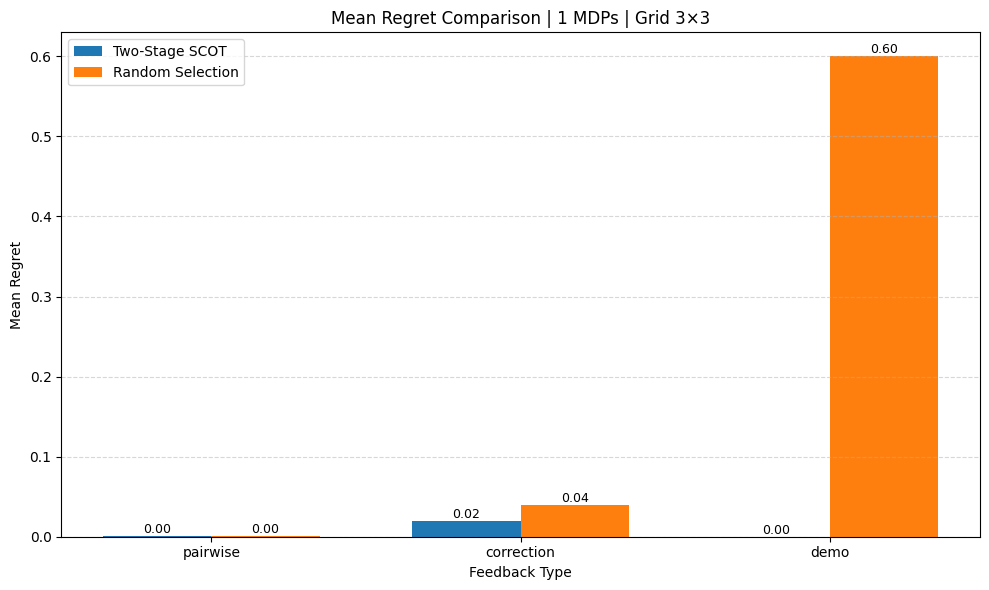

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_regret_from_values(
    feedback_to_values,
    *,
    n_envs=None,
    mdp_size=None,
    random_trials=None,
    sort_by_random=False,
    show_values=True,
):
    """
    Parameters
    ----------
    feedback_to_values : dict
        {
            "feedback_name": (two_stage_mean, random_mean)
        }

    n_envs : int or None
    mdp_size : int or None
    random_trials : int or None

    sort_by_random : bool
        If True, sort feedback types by random mean regret (ascending).

    show_values : bool
        If True, print numeric values on top of bars.
    """

    feedback_names = []
    two_stage_means = []
    random_means = []

    # ---------------- Collect values ----------------
    for feedback, (two_stage, random_val) in feedback_to_values.items():
        feedback_names.append(feedback)
        two_stage_means.append(float(two_stage))
        random_means.append(float(random_val))

    feedback_names = np.array(feedback_names)
    two_stage_means = np.array(two_stage_means)
    random_means = np.array(random_means)

    # ---------------- Optional sorting ----------------
    if sort_by_random:
        order = np.argsort(random_means)
        feedback_names = feedback_names[order]
        two_stage_means = two_stage_means[order]
        random_means = random_means[order]

    # ---------------- Plot ----------------
    x = np.arange(len(feedback_names))
    width = 0.35

    plt.figure(figsize=(10, 6))

    bars_scot = plt.bar(
        x - width / 2,
        two_stage_means,
        width,
        label="Two-Stage SCOT",
    )

    bars_random = plt.bar(
        x + width / 2,
        random_means,
        width,
        label="Random Selection",
    )

    plt.xticks(x, feedback_names)
    plt.xlabel("Feedback Type")
    plt.ylabel("Mean Regret")

    title_parts = ["Mean Regret Comparison"]
    if n_envs is not None:
        title_parts.append(f"{n_envs} MDPs")
    if mdp_size is not None:
        title_parts.append(f"Grid {mdp_size}×{mdp_size}")
    if random_trials is not None:
        title_parts.append(f"Random Trials = {random_trials}")

    plt.title(" | ".join(title_parts))

    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    # ---------------- Value labels ----------------
    if show_values:
        def annotate(bars):
            for bar in bars:
                h = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    h,
                    f"{h:.2f}",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

        annotate(bars_scot)
        annotate(bars_random)

    plt.show()

feedback_to_values = {
    "demo":      (0, 0.6),
    "pairwise":  (0.001, 0.001),
    "correction":(0.02, 0.04),
}

plot_grouped_regret_from_values(
    feedback_to_values,
    n_envs=1,
    mdp_size=3,
    #random_trials=1000,
    sort_by_random=True,
)

### Working with env API

In [ ]:
env = SimpleEnv(render_mode="human")
env.reset(seed=0)

size, wall_mask, lava_mask, lava_cells, goal_yx = build_static_maps(env)

print("=== ENV INFO ===")
print("Grid size:", size)
print("Goal (y,x):", goal_yx)
print("FEATURE_SET:", FEATURE_SET)
print("Reward weights (normalized):", l2_normalize(W_MAP[FEATURE_SET]))
print("================\n")

manual = ManualControlStateReward(
    env=env,
    wall_mask=wall_mask,
    lava_mask=lava_mask,
    lava_cells=lava_cells,
    goal_yx=goal_yx,
    size=size,
)


print("Controls:")
print("  LEFT  = turn left")
print("  RIGHT = turn right")
print("  UP    = move forward")
print("  ESC   = quit\n")
manual.start()

### Generating random trajectories and pairwise preferneces

### testing pairwise preference generation

### Correction feedback